<a href="https://colab.research.google.com/github/TheWiseGhost/Power_Consumption_ML/blob/main/Power_Consumption_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This dataset is related to power consumption of three different distribution networks of Tetouan city which is located in north Morocco.

By A. Salam, A. E. Hibaoui. 2018 Published in International Renewable and Sustainable Energy Conference
https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city

Preparing the dataframe

In [2]:
# Started 1/1/24
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

In [218]:
cols = ['DateTime', 'Temperature', 'Humidity', 'Wind Speed', 'General Diffuse Flows', 'Diffuse Flows', 'Power Consumption', 'Z2', 'Z3']

# Model will only look at Zone 1 and DateTime of 9:00 to avoid variation in data
df = pd.read_csv('/content/power_consumption_of_tetouan_city.data.zip', names=cols, skiprows=1).drop(['Z2', 'Z3'], axis=1)
drop_list = []
for x in range(0, 52416):
  if (x - 54) % 144 != 0:
    if x -54 != 0:
      drop_list.append(x)

df = df.drop(drop_list)

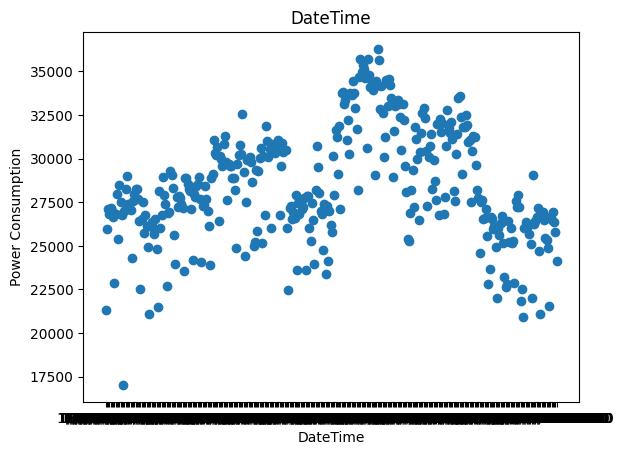

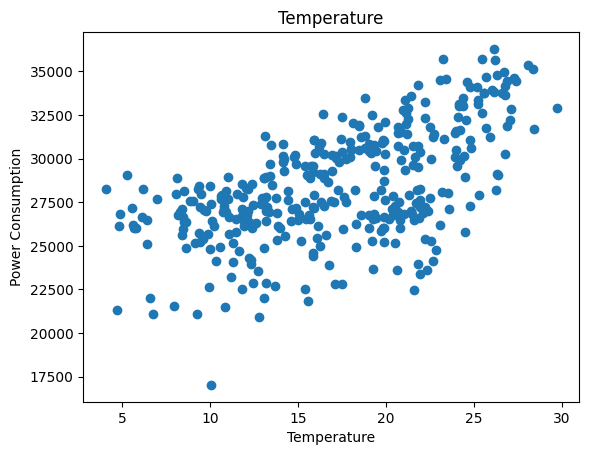

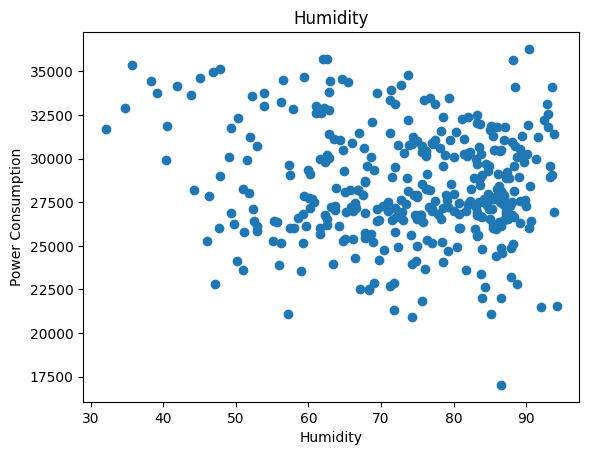

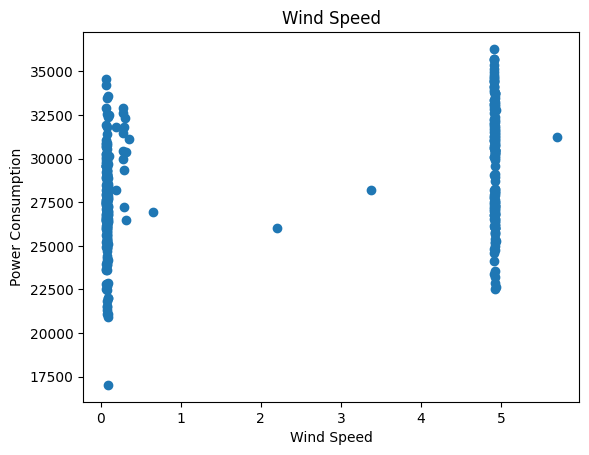

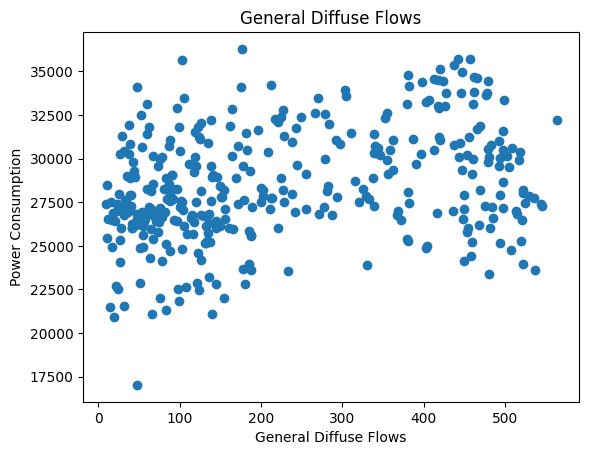

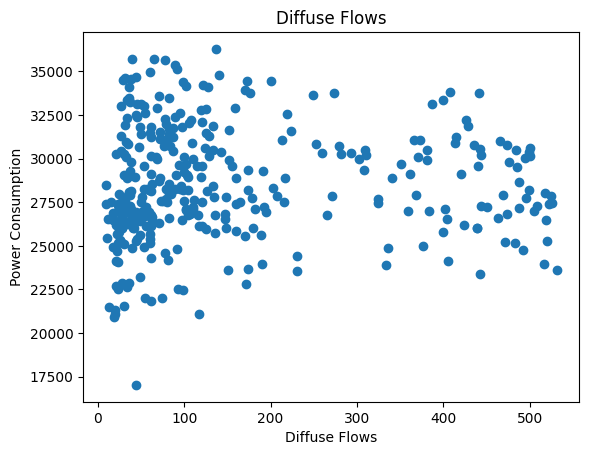

In [219]:
# Analyze the graphs to see the ones with strong linear relationships
for label in df.columns[:-1]:
  plt.scatter(df[label], df['Power Consumption'])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel("Power Consumption")
  plt.show()

In [220]:
# Drop the ones without any linear relationship
df = df.drop(['DateTime', 'Wind Speed'], axis=1)

In [180]:
df.head()

,Temperature,Humidity,General Diffuse Flows,Diffuse Flows,Power Consumption
54,4,71.8,82.50,20.15,21296.20253
198,8,85.9,64.11,24.49,25980.75949
342,8,85.3,64.80,27.42,27135.18987
486,4,87.2,70.50,26.46,26849.62025
630,5,78.6,75.10,25.83,27153.41772


Splitting the dataframe

In [202]:
training_data, validation_data, test_data = np.split(df.sample(frac=1), [int(len(df)*0.6), int(len(df)*0.8)])

In [203]:
def get_xy(df, y_label, x_labels=None):
  # Deep copying creates an independent copy, preserving the original list’s contents even after changes to the copy
  df = copy.deepcopy(df)

  x = df[x_labels].values
  if len(x_labels) == 1:
    x = x.reshape(len(x), 1)

  y = df[y_label].values
  y = y.reshape(len(y), 1)

  data = np.hstack((x, y))

  return data, x, y

In [204]:
training_data, x_train, y_train = get_xy(training_data, 'Power Consumption', x_labels=df.columns[:-1])
validation_data, x_validation, y_validation = get_xy(validation_data, 'Power Consumption', x_labels=df.columns[:-1])
test_data, x_test, y_test = get_xy(test_data, 'Power Consumption', x_labels=df.columns[:-1])

Creating Models

In [205]:
normalizer = tf.keras.layers.Normalization(input_shape=(4,), axis=1)

normalizer.adapt(x_train)

In [206]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

In [207]:
lin_reg.score(x_test, y_test)

0.28396050108429904

In [208]:
nn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(tf.keras.optimizers.Adam(0.01), loss='mean_squared_error')

In [209]:
history = nn_model.fit(
    x_train, y_train,
    epochs = 100,
    verbose = 0,
    validation_data = [x_validation, y_validation]
)

In [210]:
def plot_loss(data):
  plt.plot(data.history['loss'], label='Loss', color='blue')
  plt.plot(data.history['val_loss'], label='val_loss', color='red')
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid()
  plt.show()

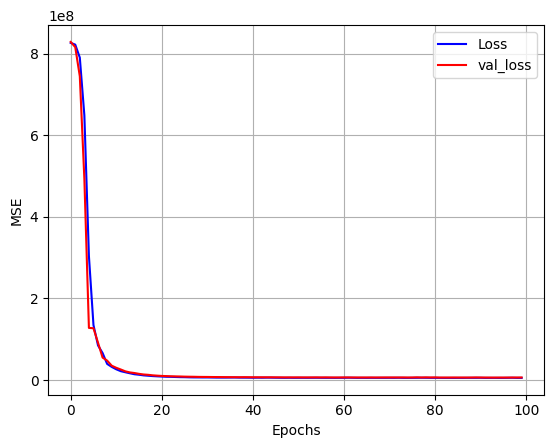

In [211]:
plot_loss(history)

Comparing Models

In [222]:
y_pred_nn = nn_model.predict(x_test)
y_pred_lin_reg = lin_reg.predict(x_test)

3/3 [==============================] - 0s 3ms/step


In [223]:
def MSE_calc(pred, actual):
  return (np.square(pred-actual)).mean()

In [224]:
MSE_calc(y_pred_nn, y_test)

7553572.973416405

In [225]:
MSE_calc(y_pred_lin_reg, y_test)

6998725.2207136545

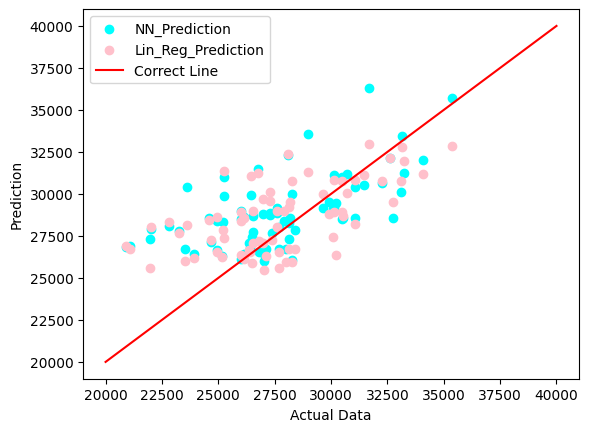

In [226]:
# See if the predictions were mostly over or under or what happened vs the actual data
plt.scatter(y_test, y_pred_nn, label='NN_Prediction', color='cyan')
plt.scatter(y_test, y_pred_lin_reg, label='Lin_Reg_Prediction', color='pink')
plt.xlabel('Actual Data')
plt.ylabel('Prediction')
plt.plot([20000, 40000], [20000, 40000], label='Correct Line', color='red')
plt.legend()
plt.show()

FOR NN_MODEL:
Results are indicating that the slope could have higher for more accuracy
The first "half-interval" of the predictions is above yet the second half is almost entirely below the the line.

FOR LIN_REG MODEL:
Basically the exact same results as the NN_MODEL. Makes sense as the MSE was almost the same for the two models

CONCLUSION:
It seems like that both model are choosing a very low slope in order to minimize the harsh penalities caused by MSE. Maybe a better model would use another form of loss minimization other than MSE. However, what likely occured was a programming error on my part as the slope of both lines seem incredibily low compared to the data. Surprisingly, the NN model performed worse than Lin_Reg one. Also, maybe linear regression based models were not the best in this case as we saw how influential DateTime was in power consumption with its strong quadratic curve.